# **Heston Model Project**
Anita Mezzetti 

course: Machine Learning for finance

Table of context:
- [Explicit solution of the Heston price equation](#solution)
- [Stock paths generator](#stock)
- [Generate data](#data)
- [Monte Carlo simulation](#mc)
    - [Monte Carlo simulation with Antithetic variables](#mcav)
- [Data Creation for ML methods](#header2)


### Import packages

In [80]:
import numpy as np
import pandas as pd
import math as math
import cmath as cmath
from scipy import integrate
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Explicit solution of the Heston price equation <a class="anchor" id="solution"></a>
In this section, we define the functions needed to find the numberical solution:
$$ C(S,T) = S P_1 - K P_2 $$
More details in the report

In [2]:
# characteristic function
def f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status):
    
    a = kappa * theta
    x = math.log(s0)
    
    # remind that lamda is zero
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa
    
    d = cmath.sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2 * u * phi * 1j - phi**2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    
    C = r * phi * 1j * T + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * cmath.log((1 - g * cmath.exp(d * T))/(1 - g)))
    D = (b - rho * sigma * phi * 1j + d) / sigma**2 * ((1 - cmath.exp(d * T)) / (1 - g * cmath.exp(d * T)))
    
    return cmath.exp(C + D * v0 + 1j * phi * x)

In [3]:
# P1 and P2
def p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status):
    
    
    integrand = lambda phi: (cmath.exp(-1j * phi * cmath.log(K)) * f(phi, kappa, \
                              theta, sigma, rho, v0, r, T, s0, status) / (1j * phi)).real 
    
    return (0.5 + (1 / math.pi) * integrate.quad(integrand, 0, 100)[0]) # approximate indefinite intergral with a definite one

def p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1)

def p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2)


In [4]:
# call price
def call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    
    P1 = p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    P2 = p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    
    result = (s0 * P1 - K * math.exp(-r * T) * P2)
    
    if result<0:
        result = 0
        
    return result

# Stock paths generator <a class="anchor" id="stock"></a>
We define the functions needed to create the stock paths using the Heston model dynamic:


In [5]:
# generate the stock price simulation
def stock_price_generator (T, n , m, r, S0, k, V0, sigma, theta, kappa, rho, generator, entire_stock=False ):
    dt = T / n
    
    # Brownian motions:
    dw_v = generator.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = generator.normal(size=(m, n)) * np.sqrt(dt)

    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0

    v = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        s[:, t + 1] = s[:, t] + ds
        
    if entire_stock==False: # return only the stocks simulation at T
        result = s[:,-1]; 
    else:
        result = s; # return all the stock dynamic
        
    return result
    

In [6]:
# find the stock price from ST as expected return
def find_expected_payoff(stock_path, k, r, t_max):
    payoff = max(stock_path[-1] - k, 0) # one payoff for each simulation
    c = payoff * np.exp(-r * t_max)     # in case r=0, this step is useless
    
    return c

# Generate Data <a class="anchor" id="data"></a>

- [all values fixed apart S0](#data1)
- [all values fixed apart S0 and T](#data2)
- [all values fixed apart S0 and r](#data3)
- [all values fixed apart S0 and V0](#data4)
- [all values fixed apart S0, T and V0](#data5)

In [7]:
generator = np.random.default_rng()

**- All values fixed apart S0**

In [12]:
# set parameters and constants
r = 0
k = 2
V0 = 0.01
sigma = 0.6
theta = 0.02
kappa = 6.21
T1 = 10
rho = -0.5

S0 = np.arange(1,4,0.1)

In [13]:
time_maturity = 3
num_simulations = 100
n = 250 # numbers of division of the time 

In [14]:
df1 = pd.DataFrame(columns=['stock_zero', 'price'])

In [15]:
# fill the dataset
for s0 in S0:
    s = stock_price_generator (time_maturity, n, num_simulations, r, s0, k, V0, sigma, theta, kappa, rho, generator, entire_stock=True)

    for stock_path in s: # for each simulation
        price = find_expected_payoff(stock_path, k, r, time_maturity)
        
        new_row = {
                      'price':price, 
                      'stock_zero':stock_path[T1],
                  }
        #append row to the dataframe
        df1 = df1.append(new_row, ignore_index=True)

In [16]:
df1.head()

,stock_zero,price
0,1.030967,0.0
1,1.023386,0.0
2,1.039906,0.0
3,0.967509,0.0
4,0.991601,0.0


In [17]:
len(df1)

3000

# Monte Carlo simulation  <a class="anchor" id="mc"></a>

In [64]:
# function which finds the expected payoff 
def find_mc_price(sT, k, r, T):
    final = sT - k
    payoff = [max(x,0) for x in final] # one payoff for each simulation
    payoff = np.asarray(payoff)
    
    expected_payoff = payoff.mean() # mean
    
    c = expected_payoff * np.exp(-r * T)     # in case r=0, this step is useless
    
    return c

In [65]:
num_sim_mc = 1000

**- All values fixed apart S0**

In [66]:
df1_mc = pd.DataFrame(columns=['stock_zero', 'mc_price', 'num_price'])

In [67]:
# find the mc price
for s0 in S0:
    sT = stock_price_generator (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)

    mc = find_mc_price(sT, k, r, time_maturity)
    
    num_price = call_price(kappa, theta, sigma, rho, V0, r, time_maturity, s0, k)

    new_row = {
                  'mc_price':mc, 
                  'stock_zero':s0,
                  'num_price': num_price,
              }
    #append row to the dataframe
    df1_mc = df1_mc.append(new_row, ignore_index=True)

In [68]:
df1_mc.head()

,stock_zero,mc_price,num_price
0,1.0,0.000000,0.0
1,1.1,0.001246,0.0
2,1.2,0.002806,0.0
3,1.3,0.001469,0.0
4,1.4,0.009668,0.0


In [69]:
len(df1_mc)

30

## Monte Carlo simulation with Antithetic variables <a class="anchor" id="mcav"></a>

In [70]:
def stock_price_generator_av (T, n ,m, r, S0, k, V0, sigma, theta, kappa, rho, separate=False):
    dt = T / n
    
    m = int(m/2) # with av we can do half of the simulations
    n = int(n)
    
    # Brownian motions:
    dw_v = generator.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = generator.normal(size=(m, n)) * np.sqrt(dt)

    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0
    
    s_ant = np.empty((m, n + 1))
    s_ant[:, 0] = S0

    v = np.ones(m) * V0
    v_ant = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        dv_ant = kappa * (theta - v_ant) * dt + sigma * np.sqrt(v_ant) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]
        ds_ant = r * s_ant[:, t] * dt + np.sqrt(v_ant) * s_ant[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        v_ant = np.clip(v_ant + dv_ant, a_min=0.0, a_max=None)
        
        s[:, t + 1] = s[:, t] + ds
        s_ant[:, t + 1] = s_ant[:, t] + ds_ant
        
    if separate==True:
        return s, s_ant
        
    return np.concatenate((s, s_ant))[:,-1]

In [71]:
mc_price_av = []

In [72]:
# find the mc price
for s0 in S0:
    ST_ant = stock_price_generator_av (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)
    mc_av = find_mc_price(ST_ant, k, r, time_maturity)
    
    mc_price_av.append(mc_av)

In [73]:
df1_mc['mc_price_av'] = mc_price_av

In [74]:
df1_mc.head()

,stock_zero,mc_price,num_price,mc_price_av
0,1.0,0.000000,0.0,0.000000
1,1.1,0.001246,0.0,0.000000
2,1.2,0.002806,0.0,0.000345
3,1.3,0.001469,0.0,0.001696
4,1.4,0.009668,0.0,0.009854


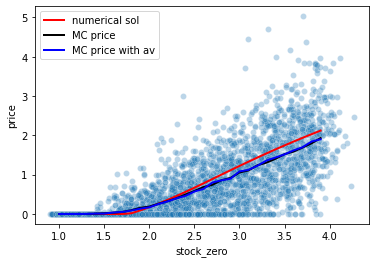

In [75]:
import seaborn as sns
sns.scatterplot(data=df1, x="stock_zero", y="price", alpha =0.3)
plt.plot(S0, df1_mc.num_price, color='r', linewidth=2, label='numerical sol')
plt.plot(S0, df1_mc. mc_price, color='black', linewidth=2, label='MC price')
plt.plot(S0, df1_mc. mc_price_av, color='blue', linewidth=2, label='MC price with av')
plt.legend()
plt.show()

The result with mc and mc_av are quite similar. let us know the difference in terms standard deviation and time needed to compute them 

### Time analysis

In [84]:
start = time.time()
for s0 in S0:
    ST_ant = stock_price_generator (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)
    mc_av = find_mc_price(ST_ant, k, r, time_maturity)
end = time.time()
time_cm = end - start
print(f"Time needed for Monte Carlo: {time_cm}")

Time needed for Monte Carlo: 1.6491951942443848


In [85]:
start = time.time()
for s0 in S0:
    ST_ant = stock_price_generator_av (time_maturity, n, num_sim_mc, r, s0, k, V0, sigma, theta, kappa, rho, generator)
    mc_av = find_mc_price(ST_ant, k, r, time_maturity)
end = time.time()
time_cmav = end - start
print(f"Time needed for Monte Carlo with AV: {time_cmav}")

Time needed for Monte Carlo with AV: 1.4530432224273682


In [91]:
perc_faster = (time_cm - time_cmav) / time_cm *100
perc_faster = round(perc_faster,2)
print(f"Monte Carlo with AV is {perc_faster}% faster tham the usual Monte Carlo")

Monte Carlo with AV is 11.89% faster tham the usual Monte Carlo
